## Baseline Model

In [0]:
#standard imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.sql.functions import log1p
import pyspark.sql.functions as f
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
import numpy as np
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import unix_timestamp, to_date, col
from pyspark.sql.functions import col, log1p, when, lit, row_number, hour, dayofweek, unix_timestamp, minute
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors # For converting Spark Vectors to dense arrays if needed
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [0]:
#class weights

# Apply sampling on train if selected (Vini's sample code)
# if sampling=='down':
# train_df = downsample(train_df)
# train_df = train_df.cache()
# elif sampling=='up':
# train_df = upsample(train_df)
# train_df = train_df.cache()
# elif sampling=='weights': #look into THIS part 
# train_df = add_class_weights(train_df).cache()



In [0]:
#time window format
def data_set(time):
    if time == 3:
        return "_3m"
    elif time == 6:
        return "_6m"
    elif time == 12:
        return "_1y"
    elif time == 'all':
        return ""
    else:
        raise ValueError("time must be 3, 6, 12, or 'all'")

In [0]:
#Evaluates Classification Model (Precision, Recall, F2, PR-AUC)
#Confusion Matrix (can remove but for visual)
def cv_eval(preds):
    """
    Input: preds = Spark DF with prediction, ARR_DEL15, probability
    Output: F2, PR-AUC, Precision, Recall, TP, FP, FN, TN
    """

    rdd_preds_m = preds.select(
        ['prediction', 'ARR_DEL15']
    ).rdd.map(lambda row: (float(row['prediction']), float(row['ARR_DEL15'])))

    rdd_preds_b = preds.select(
        ['probability', 'ARR_DEL15']
    ).rdd.map(lambda row: (float(row['probability'][1]), float(row['ARR_DEL15'])))

    metrics_m = MulticlassMetrics(rdd_preds_m)
    metrics_b = BinaryClassificationMetrics(rdd_preds_b)

    # ---- Metrics ----
    precision = round(metrics_m.precision(1.0), 4)
    recall = round(metrics_m.recall(1.0), 4)
    F2 = round(metrics_m.fMeasure(label=1.0, beta=2.0), 4)
    pr_auc = round(metrics_b.areaUnderPR, 4)

    # ---- Confusion Matrix ----
    cm = metrics_m.confusionMatrix().toArray()

    # cm layout:
    # [[TN, FP],
    #  [FN, TP]]

    TN = int(cm[0, 0])
    FP = int(cm[0, 1])
    FN = int(cm[1, 0])
    TP = int(cm[1, 1])

    return F2, pr_auc, precision, recall, TP, FP, FN, TN



In [0]:
#manually plot PR-AUC curve
def plot_pr(preds, title="Precision–Recall Curve"):
    # get (score, label)
    rows = preds.select("probability", "ARR_DEL15").collect()
    data = [(float(r["probability"][1]), float(r["ARR_DEL15"])) for r in rows]

    # sort descending by score
    data.sort(key=lambda x: -x[0])

    tp = 0
    fp = 0
    positives = sum(y for _, y in data)

    recalls = []
    precisions = []

    for score, label in data:
        if label == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall    = tp / positives

        precisions.append(precision)
        recalls.append(recall)

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid()
    plt.show()


In [0]:
#probability vector for baseline predictions

from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) #ignore warnings

# Builds the probability vector (returns type VectorUDT to avoid pickling error)
def prob_vector(label):
    return Vectors.dense([1.0, 0.0]) if label == 0 else Vectors.dense([0.0, 1.0])
    
prob_udf = udf(prob_vector, VectorUDT()) 
#udf converts the Python function so Spark can use it on columns.
#VectorUDT() tells Spark that the returned value is a Vector type, not a list.

## Evaluate Baseline Model

In [0]:
def evaluate_baseline_on_folds(folds_input_path, N_SPLITS=4, plot_pr_curve=True):
    from pyspark.sql import functions as F

    scores_f2 = []
    scores_pr = []
    scores_precision = []
    scores_recall = []
    confusion_list = []  # Store TP/FP/FN/TN for each fold

    for i in range(N_SPLITS):
        print(f"\n==============================")
        print(f" Fold {i+1}")
        print(f"==============================")

        # Load data
        train_df = spark.read.parquet(f"{folds_input_path}/fold_{i+1}_train")
        val_df = spark.read.parquet(f"{folds_input_path}/fold_{i+1}_val")

        # Majority class baseline
        majority_class = (
            train_df.groupBy("ARR_DEL15")
            .count()
            .orderBy(F.desc("count"))
            .first()[0]
        )

        preds_baseline = (
            val_df
            .withColumn("prediction", F.lit(float(majority_class)))
            .withColumn("probability", prob_udf(F.lit(majority_class)))
        )

        # Quick check — distribution of true labels in fold
        preds_baseline.groupBy("ARR_DEL15").count().show()

        # ---- Compute all metrics ----
        f2, pr_auc, precision, recall, TP, FP, FN, TN = cv_eval(preds_baseline)

        # Store per-fold values
        scores_f2.append(f2)
        scores_pr.append(pr_auc)
        scores_precision.append(precision)
        scores_recall.append(recall)
        confusion_list.append({"TP": TP, "FP": FP, "FN": FN, "TN": TN})

        # ---- Print fold metrics ----
        print(f"Majority Class      : {majority_class}")
        print(f"F2 Score            : {f2:.4f}")
        print(f"PR-AUC              : {pr_auc:.4f}")
        print(f"Precision           : {precision:.4f}")
        print(f"Recall              : {recall:.4f}")
        print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")

        if plot_pr:
            plot_pr(preds_baseline, title=f"Precision–Recall Curve (Fold {i+1})")

    # ---- Return summary results ----
    return {
        "f2_scores": scores_f2,
        "pr_auc_scores": scores_pr,
        "precision_scores": scores_precision,
        "recall_scores": scores_recall,
        "confusion": confusion_list,

        "f2_mean": float(np.mean(scores_f2)),
        "f2_std": float(np.std(scores_f2)),

        "pr_auc_mean": float(np.mean(scores_pr)),
        "pr_auc_std": float(np.std(scores_pr)),

        "precision_mean": float(np.mean(scores_precision)),
        "precision_std": float(np.std(scores_precision)),

        "recall_mean": float(np.mean(scores_recall)),
        "recall_std": float(np.std(scores_recall)),
    }

### Run for 3 months


 Fold 1
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1| 2580|
|        0|15599|
+---------+-----+

Majority Class      : 0
F2 Score            : 0.0000
PR-AUC              : 0.1419
Precision           : 0.0000
Recall              : 0.0000
TP=0, FP=0, FN=2580, TN=15599


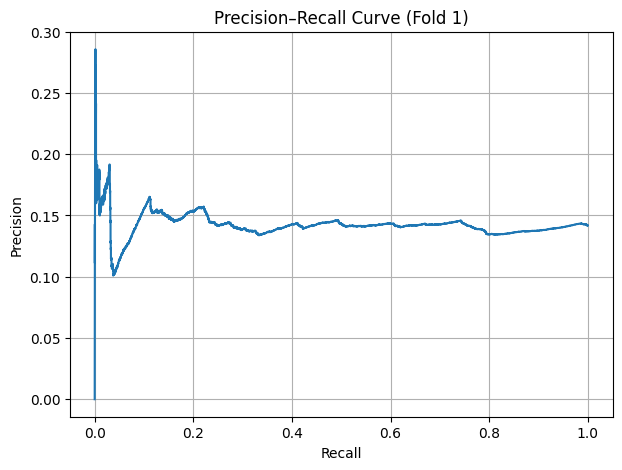


 Fold 2
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1| 3897|
|        0|14282|
+---------+-----+

Majority Class      : 0
F2 Score            : 0.0000
PR-AUC              : 0.2144
Precision           : 0.0000
Recall              : 0.0000
TP=0, FP=0, FN=3897, TN=14282


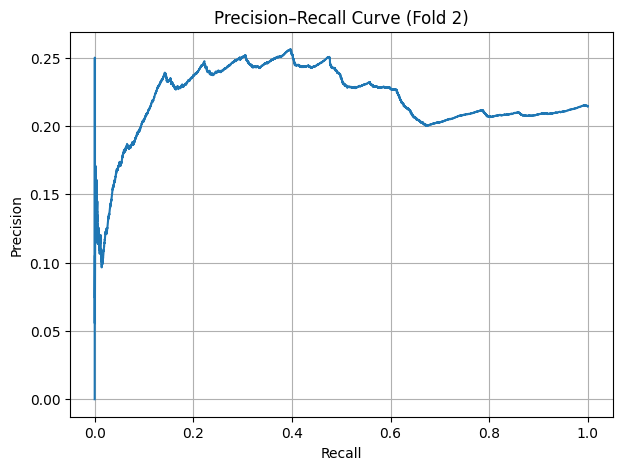


 Fold 3
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1| 5029|
|        0|13150|
+---------+-----+

Majority Class      : 0
F2 Score            : 0.0000
PR-AUC              : 0.2766
Precision           : 0.0000
Recall              : 0.0000
TP=0, FP=0, FN=5029, TN=13150


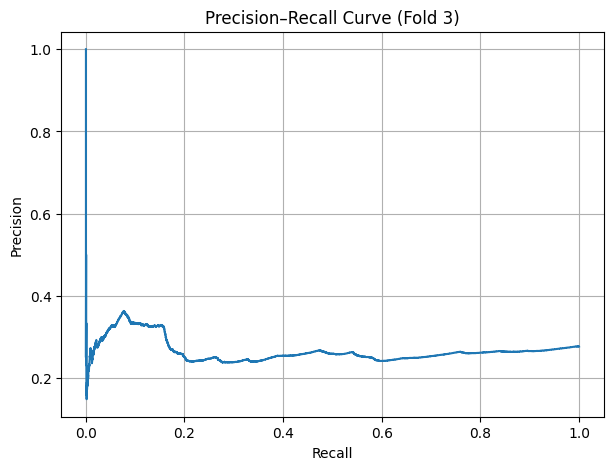


 Fold 4
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1| 3849|
|        0|14334|
+---------+-----+

Majority Class      : 0
F2 Score            : 0.0000
PR-AUC              : 0.2117
Precision           : 0.0000
Recall              : 0.0000
TP=0, FP=0, FN=3849, TN=14334


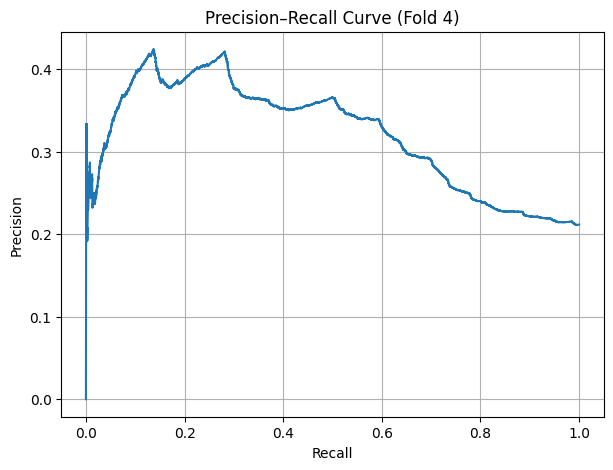

{'f2_scores': [0.0, 0.0, 0.0, 0.0],
 'pr_auc_scores': [0.1419, 0.2144, 0.2766, 0.2117],
 'precision_scores': [0.0, 0.0, 0.0, 0.0],
 'recall_scores': [0.0, 0.0, 0.0, 0.0],
 'confusion': [{'TP': 0, 'FP': 0, 'FN': 2580, 'TN': 15599},
  {'TP': 0, 'FP': 0, 'FN': 3897, 'TN': 14282},
  {'TP': 0, 'FP': 0, 'FN': 5029, 'TN': 13150},
  {'TP': 0, 'FP': 0, 'FN': 3849, 'TN': 14334}],
 'f2_mean': 0.0,
 'f2_std': 0.0,
 'pr_auc_mean': 0.21115,
 'pr_auc_std': 0.047671086624913435,
 'precision_mean': 0.0,
 'precision_std': 0.0,
 'recall_mean': 0.0,
 'recall_std': 0.0}

In [0]:
#Checkpoint location
dbfs_path = "dbfs:/student-groups/Group_02_01"

#RUN FOR 3 MONTH FOLDS
time = 3 #test on 3 months

# Define your existing paths
time_length = data_set(time)
splits_path = f"{dbfs_path}/splits{time_length}"
folds_input_path = f"{splits_path}/scaled_smote_folds" #use scaled_smote_folds

#run evaluation
baseline_results_3m = evaluate_baseline_on_folds(
    folds_input_path=folds_input_path,
    N_SPLITS=4,
    plot_pr_curve=True  #  <- don't plot PR-AUC curves (save time)
)

baseline_results_3m


##Run for 1 year


 Fold 1
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1|18760|
|        0|78931|
+---------+-----+

Majority Class      : 1
F2 Score            : 0.5430
PR-AUC              : 0.1920
Precision           : 0.1920
Recall              : 1.0000
TP=18760, FP=78931, FN=0, TN=0


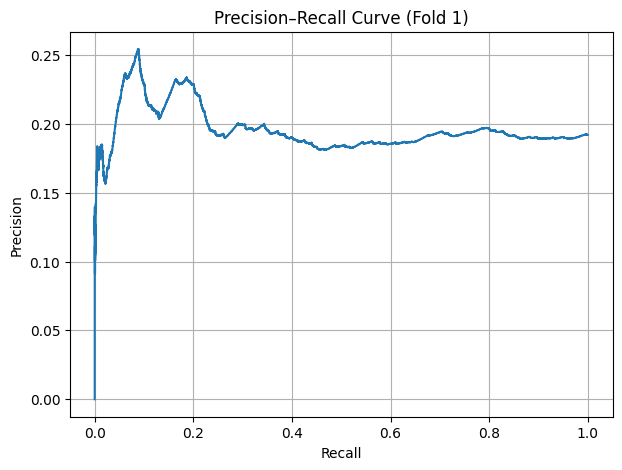


 Fold 2
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1|25370|
|        0|72321|
+---------+-----+

Majority Class      : 1
F2 Score            : 0.6369
PR-AUC              : 0.2597
Precision           : 0.2597
Recall              : 1.0000
TP=25370, FP=72321, FN=0, TN=0


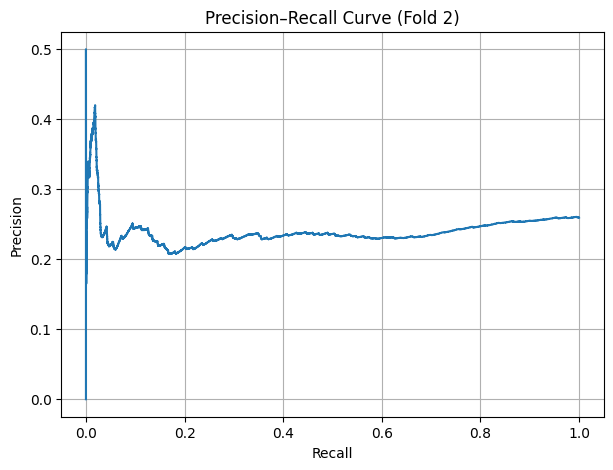


 Fold 3
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1|25598|
|        0|72093|
+---------+-----+

Majority Class      : 0
F2 Score            : 0.0000
PR-AUC              : 0.2620
Precision           : 0.0000
Recall              : 0.0000
TP=0, FP=0, FN=25598, TN=72093


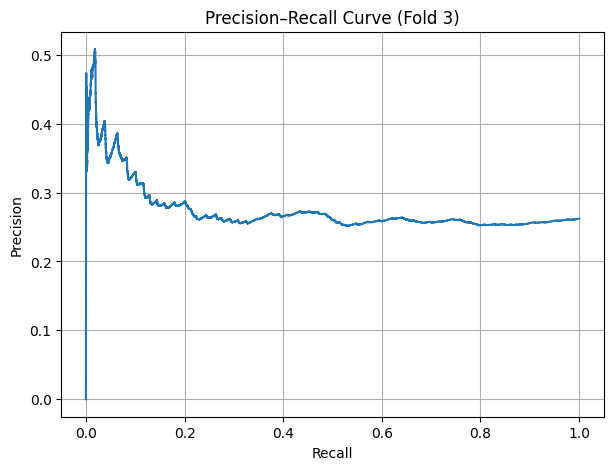


 Fold 4
+---------+-----+
|ARR_DEL15|count|
+---------+-----+
|        1|16472|
|        0|81222|
+---------+-----+

Majority Class      : 1
F2 Score            : 0.5035
PR-AUC              : 0.1686
Precision           : 0.1686
Recall              : 1.0000
TP=16472, FP=81222, FN=0, TN=0


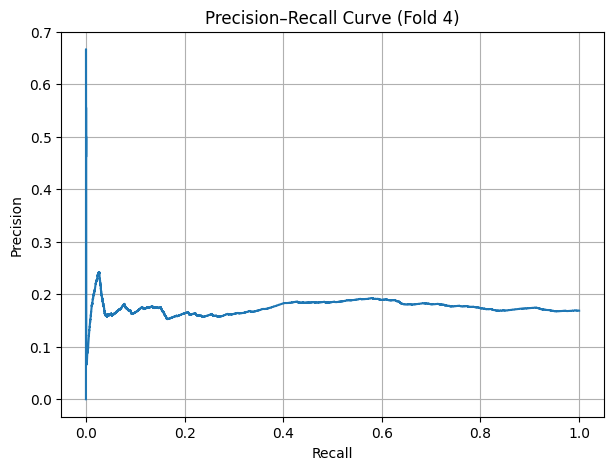

{'f2_scores': [0.543, 0.6369, 0.0, 0.5035],
 'pr_auc_scores': [0.192, 0.2597, 0.262, 0.1686],
 'precision_scores': [0.192, 0.2597, 0.0, 0.1686],
 'recall_scores': [1.0, 1.0, 0.0, 1.0],
 'confusion': [{'TP': 18760, 'FP': 78931, 'FN': 0, 'TN': 0},
  {'TP': 25370, 'FP': 72321, 'FN': 0, 'TN': 0},
  {'TP': 0, 'FP': 0, 'FN': 25598, 'TN': 72093},
  {'TP': 16472, 'FP': 81222, 'FN': 0, 'TN': 0}],
 'f2_mean': 0.42084999999999995,
 'f2_std': 0.24776196742034481,
 'pr_auc_mean': 0.220575,
 'pr_auc_std': 0.041123981750312066,
 'precision_mean': 0.155075,
 'precision_std': 0.09557853773206619,
 'recall_mean': 0.75,
 'recall_std': 0.4330127018922193}

In [0]:
#RUN FOR 12 MONTH 
time = 12 #1 yr

# Define your existing paths
time_length = data_set(time)
splits_path = f"{dbfs_path}/splits{time_length}"
folds_input_path = f"{splits_path}/scaled_smote_folds" #use scaled_smote_folds

#run evaluation
baseline_results_1yr = evaluate_baseline_on_folds(
    folds_input_path=folds_input_path,
    N_SPLITS=4,
    plot_pr_curve=True   #  <- enable PR-AUC curves
)

baseline_results_1yr


## Further Visualization of 1yr Baseline Results

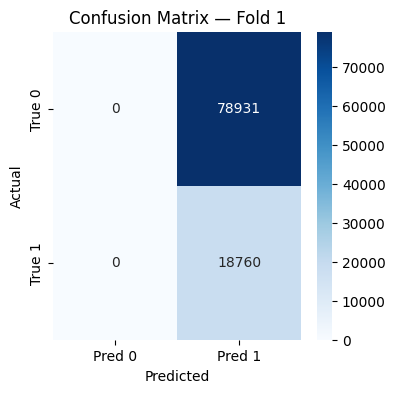

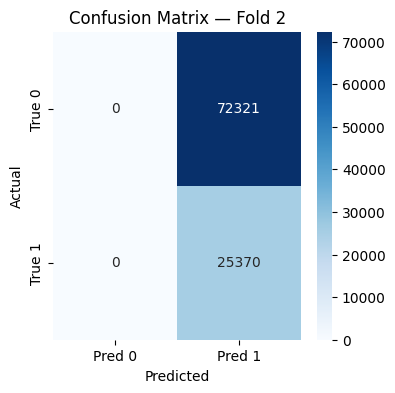

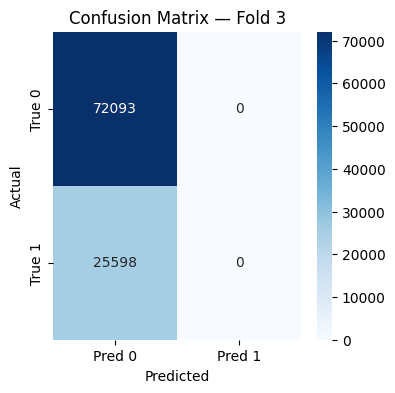

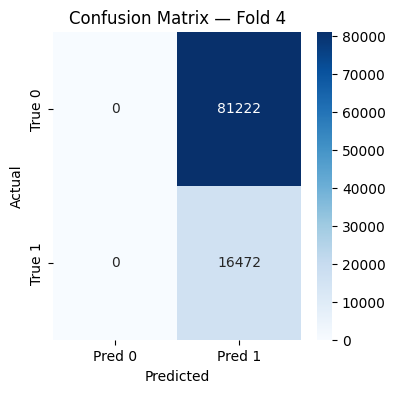

In [0]:
#One heatmap per fold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion = [{'TP': 18760, 'FP': 78931, 'FN': 0, 'TN': 0},
  {'TP': 25370, 'FP': 72321, 'FN': 0, 'TN': 0},
  {'TP': 0, 'FP': 0, 'FN': 25598, 'TN': 72093},
  {'TP': 16472, 'FP': 81222, 'FN': 0, 'TN': 0}]

for i, cm in enumerate(confusion):
    matrix = np.array([[cm["TN"], cm["FP"]],
                       [cm["FN"], cm["TP"]]])

    plt.figure(figsize=(4,4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix — Fold {i+1}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

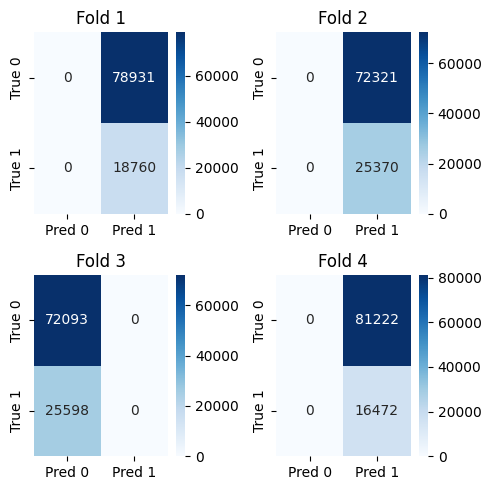

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))

for idx, ax in enumerate(axes.flat):
    cm = confusion[idx]
    matrix = np.array([[cm["TN"], cm["FP"]],
                       [cm["FN"], cm["TP"]]])

    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)
    ax.set_title(f"Fold {idx+1}")

plt.tight_layout()
plt.show()

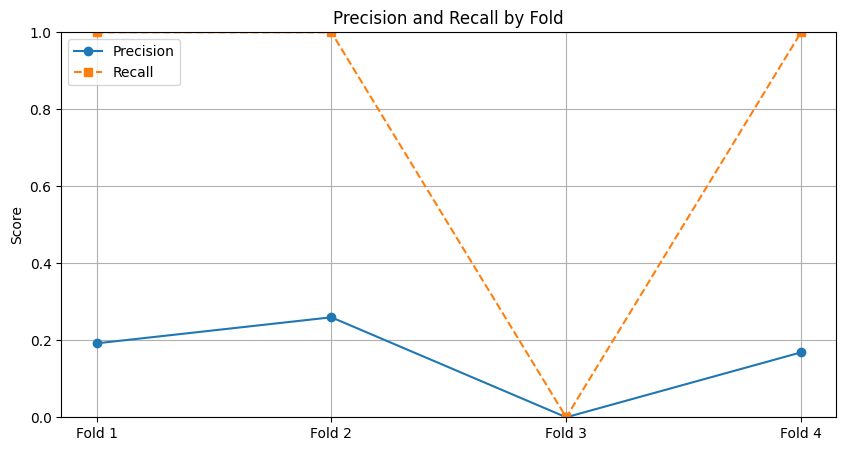

In [0]:
#Precision and Recall by Fold (need to label TRAIN vs. VALIDATION)

folds = [1, 2, 3, 4]
f2_scores = [0.543, 0.6369, 0.0, 0.5035]
pr_auc_scores = [0.192, 0.2597, 0.262, 0.1686]
precision_scores = [0.192, 0.2597, 0.0, 0.1686]
recall_scores = [1.0, 1.0, 0.0, 1.0]

plt.figure(figsize=(10,5))
plt.plot(folds, precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(folds, recall_scores, marker='s', linestyle='--', label='Recall')
plt.xticks(folds, [f"Fold {i}" for i in folds])
plt.ylabel("Score")
plt.title("Precision and Recall by Fold")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

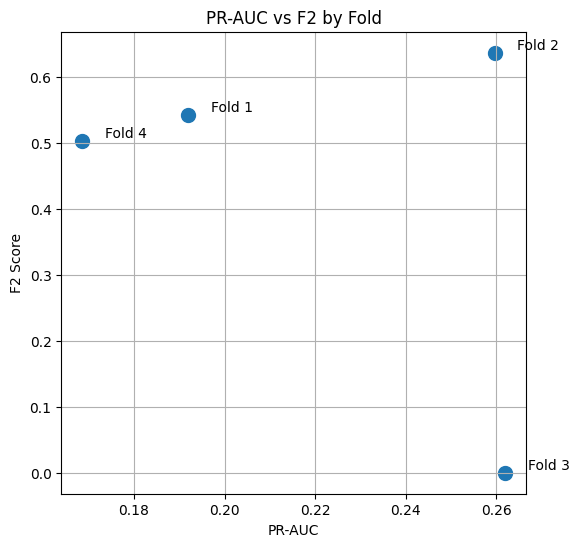

In [0]:
#PR-AUC vs F2 Scatter Plot (Spot Outliers)
plt.figure(figsize=(6,6))
plt.scatter(pr_auc_scores, f2_scores, s=100)

for i, (x,y) in enumerate(zip(pr_auc_scores, f2_scores)):
    plt.text(x+0.005, y+0.005, f"Fold {i+1}")

plt.xlabel("PR-AUC")
plt.ylabel("F2 Score")
plt.title("PR-AUC vs F2 by Fold")
plt.grid(True)
plt.show()

In [0]:
# Fold-level data
folds = [1, 2, 3, 4]
positives = [18760, 25370, 25598, 16472]
negatives = [78931, 72321, 72093, 81222]
f2_scores = [0.5430, 0.6369, 0.0, 0.5035]
pr_auc_scores = [0.1920, 0.2597, 0.2620, 0.1686]

x = np.arange(len(folds))

# ---- Bar chart for positives vs negatives ----
plt.figure(figsize=(10,5))
plt.bar(x - 0.2, positives, width=0.4, label='Delayed (1)', color='orange')
plt.bar(x + 0.2, negatives, width=0.4, label='On-Time (0)', color='skyblue')
plt.xticks(x, [f"Fold {i}" for i in folds])
plt.ylabel("Count")
plt.title("On-Time vs Delayed Flight Counts by Fold")
plt.legend()
plt.show()

# ---- Line chart for F2 and PR-AUC ----
plt.figure(figsize=(10,5))
plt.plot(folds, f2_scores, marker='o', linestyle='-', color='green', label='F2 Score')
plt.plot(folds, pr_auc_scores, marker='s', linestyle='--', color='red', label='PR-AUC')
plt.xticks(folds, [f"Fold {i}" for i in folds])
plt.ylabel("Score")
plt.title("F2 and PR-AUC by Fold")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

## Appendix

######Previous runs without pipeline construction

In [0]:
%skip
#Checkpoint location
dbfs_path = "dbfs:/student-groups/Group_02_01"

#RUN FOR 1 year
time = 12 #1 year

time_length = data_set(time)
splits_path = f"{dbfs_path}/splits{time_length}"

# Define your existing paths
folds_input_path = f"{splits_path}/scaled_smote_folds" #use scaled_smote_folds
N_SPLITS = 4  # number of folds
plot_pr = True #plot PR-AUC curve


In [0]:
%skip
#use pr(), precisionByThreshold(), recallByThreshold() to plot PR_AUC curve (depends on Spark cluster version)
# PLOT PR-AUC (Precision-Recall) curve
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

def plot_pr(preds, title="Precision–Recall Curve"):
    """
    preds must contain:
      - ARR_DEL15 (label)
      - probability (Vector with [p0, p1])
    """
    
    # Convert to (score, label)
    rdd_preds = preds.select("ARR_DEL15", "probability") \
        .rdd \
        .map(lambda row: (float(row["probability"][1]), float(row["ARR_DEL15"])))

    metrics = BinaryClassificationMetrics(rdd_preds)

    # PR points: (recall, precision)
    # pr_rdd = metrics.pr() #don't use pr() function
    # pr_points = pr_rdd.collect()

    # recalls = [float(x[0]) for x in pr_points]
    # precisions = [float(x[1]) for x in pr_points]


    # ---- Get precision/recall per threshold ----
    precision = metrics.precisionByThreshold().collect()
    recall = metrics.recallByThreshold().collect()

    # Sort by threshold so curves align
    precision = sorted(precision, key=lambda x: x[0])
    recall = sorted(recall, key=lambda x: x[0])

    # Extract values (ignore thresholds)
    precisions = [p[1] for p in precision]
    recalls = [r[1] for r in recall]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True)
    plt.show()



In [0]:
%skip
from pyspark.sql import functions as F

def add_class_weights(df, label_col="ARR_DEL15", weight_col="weight"):
    """
    Adds a class weight column to the DataFrame based on inverse class frequency.
    
    Parameters:
        df          : input Spark DataFrame
        label_col   : column holding class labels (0/1)
        weight_col  : name of new weight column

    Returns:
        DataFrame with additional weight column
    """

    # Count each class
    class_counts = df.groupBy(label_col).count().collect()
    counts_dict = {row[label_col]: row["count"] for row in class_counts}

    # Total rows
    total_count = sum(counts_dict.values())

    # Compute class weights: total / (num_classes * class_count)
    # This is the same formula used in scikit-learn class_weight="balanced"
    num_classes = len(counts_dict)
    class_weights = {cls: total_count / (num_classes * count)
                     for cls, count in counts_dict.items()}

    # Convert to broadcast variable for efficiency
    bc_weights = df.sparkSession.sparkContext.broadcast(class_weights)

    # Add weight column
    df_weighted = df.withColumn(
        weight_col,
        F.udf(lambda y: float(bc_weights.value[y]))(F.col(label_col))
    )

    return df_weighted


In [0]:
%skip
from pyspark.sql import functions as F

scores_f2 = []
scores_pr = []

for i in range(N_SPLITS):
    print(f"\nFold {i+1}")
    
    train_path = f"{folds_input_path}/fold_{i+1}_train"
    val_path = f"{folds_input_path}/fold_{i+1}_val"
    
    train_df = spark.read.parquet(train_path)
    val_df = spark.read.parquet(val_path)
    
    # Majority class baseline
    majority_class = (
        train_df.groupBy("ARR_DEL15")
        .count()
        .orderBy(F.desc("count"))
        .first()[0]
    )
    
    print(f"Majority class (Fold {i+1}): {majority_class}")

    preds_baseline = (
        val_df
        .withColumn("prediction", F.lit(float(majority_class)))
        .withColumn("probability", prob_udf(F.lit(majority_class)))
    )

    # --- Compute BOTH metrics ---
    f2, pr_auc = cv_eval(preds_baseline)
    scores_f2.append(f2)
    scores_pr.append(pr_auc)

    print(f"F2 Score (Fold {i+1}): {f2:.4f}")
    print(f"PR-AUC (Fold {i+1}): {pr_auc:.4f}")

    # --- Plot only if needed ---
    if plot_pr:   
        plt.figure(figsize=(7, 5))
        plt.bar(["F2 Score", "PR-AUC"], [f2, pr_auc], color=["lightcoral", "skyblue"])
        plt.ylabel("Score")
        plt.title(f"Fold {i+1} — Baseline Metrics")
        plt.ylim(0, 1)
        plt.grid(True, axis='y')
        plt.show()

### 3 Month Baseline Scores

In [0]:
#mean of F2 score and PR-AUC
f2_mean = np.mean(scores_f2)
f2_std  = np.std(scores_f2)

pr_mean = np.mean(scores_pr)
pr_std  = np.std(scores_pr)

print(f"F2 Baseline: {f2_mean:.4f} ± {f2_std:.4f}")
print(f"PR-AUC Baseline: {pr_mean:.4f} ± {pr_std:.4f}")

### Interpretation of 3 month results


Our F2 score for the baseline model is very low at 0.2574 meaning that the model is not capturing many true positives (low recall). It also has a fairly high variance across folds with 0.2511 variance. The PR-AUC baseline is also fairly low at 0.2112, but with a low variance across folds. The low PR-AUC score means that, on average, our baseline model has low precision and recall. The model has weak ability of identifying delays. It's only slightly better than predicting positives at random. 

In [0]:
%skip
# Add prediction column
preds_baseline = val_df.withColumn("prediction", F.lit(float(majority_class)))

# For compatibility with binary metrics, also create a probability vector
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Create probability vector [P(0), P(1)]
def prob_vector(label):
    return Vectors.dense([1.0, 0.0]) if label == 0 else Vectors.dense([0.0, 1.0])

prob_udf = udf(prob_vector, VectorUDT())
preds_baseline = preds_baseline.withColumn("probability", prob_udf(F.lit(majority_class)))

pr_auc = cv_eval(preds_baseline)[1]
print(f"PR-AUC: {pr_auc:.4f}")

### For Future Models (Evaluation Function)

##### works for ANY model (Random Forest, Logistic Regression, XGBoost-Spark




In [0]:
%skip
def run_model_cv(folds_input_path, N_SPLITS, pipeline, model, plot_pr=False):
    metrics_f2 = []
    metrics_pr = []

    for i in range(N_SPLITS):
        print(f"\n===== Fold {i+1} =====")

        train_df = spark.read.parquet(f"{folds_input_path}/fold_{i+1}_train")
        val_df = spark.read.parquet(f"{folds_input_path}/fold_{i+1}_val")

        # Fit pipeline + model
        pipeline_model = pipeline.fit(train_df)
        preds = pipeline_model.transform(val_df)

        # Evaluate
        f2, pr_auc = cv_eval(preds)
        metrics_f2.append(f2)
        metrics_pr.append(pr_auc)

        print(f"Model F2 (Fold {i+1}): {f2:.4f}")
        print(f"Model PR-AUC (Fold {i+1}): {pr_auc:.4f}")

        if plot_pr:
            plt.figure(figsize=(7,5))
            plt.bar(["F2", "PR-AUC"], [f2, pr_auc])
            plt.ylim(0, 1)
            plt.title(f"Fold {i+1} — Model Scores")
            plt.grid(True, axis='y')
            plt.show()

    return {
        "f2_scores": metrics_f2,
        "pr_auc_scores": metrics_pr,
        "f2_mean": float(np.mean(metrics_f2)),
        "f2_std": float(np.std(metrics_f2)),
        "pr_auc_mean": float(np.mean(metrics_pr)),
        "pr_auc_std": float(np.std(metrics_pr)),
    }

#### For model comparison. Model vs. baseline

In [0]:
%skip
# Your preprocessing + model pipeline
pipeline = Pipeline(stages=indexers + encoders + [model])

# ---- RUN FOR 3 MONTHS ----
baseline_3m, model_3m = run_full_pipeline(
    time_window=3,
    model=model,
    pipeline=pipeline,
    dbfs_base=dbfs_base,
    plot_pr=True
)

# # ---- RUN FOR 1 YEAR ----
# baseline_1y, model_1y = run_full_pipeline(
#     time_window=12,
#     model=model,
#     pipeline=pipeline,
#     dbfs_base=dbfs_base,
#     plot_pr=True
# )

In [0]:
%skip
run full pipeline
def run_full_pipeline(time_window, model, pipeline, dbfs_base, plot_pr=True):
    time_length = data_set(time_window)
    splits_path = f"{dbfs_base}/splits{time_length}"
    folds_input_path = f"{splits_path}/scaled_smote_folds"
    N_SPLITS = 4

    print(f"\n==== RUNNING BASELINE for {time_window}-month window ====")
    baseline_results = evaluate_baseline_on_folds(
        folds_input_path, 
        N_SPLITS=N_SPLITS,
        plot_pr=plot_pr
    )

    print("\n==== RUNNING MODEL CV ====")
    model_results = run_model_cv(
        folds_input_path,
        N_SPLITS=N_SPLITS,
        pipeline=pipeline,
        model=model,
        plot_pr=plot_pr
    )

    # Save results to DBFS as Parquet
    import pandas as pd
    results_df = pd.DataFrame([{
        "time_window": time_window,
        "baseline": baseline_results,
        "model": model_results
    }])
    spark_df = spark.createDataFrame(results_df)
    results_parquet_path = f"/student-groups/Group_02_01/splits{time_length}/results_{time_length}.parquet"
    spark_df.write.mode("overwrite").parquet(results_parquet_path)

    print(f"\nResults saved to: {results_parquet_path}")

    return baseline_results, model_results